### 변동성 돌파전략 1
변동성 돌파전략은 래리 윌리암스가 개발한 전략인데요. 이 전략으로 윌리암스는 주식투자 대회에서 많은 상을 받았다고 하네요. 심지어 딸에게 이 전략을 전수해 주었다고 합니다. 전략은 아주 간단합니다. '전날 고가와 저가의 차'에 상수 K (0.4 ~ 0.6) 를 곱하여 변동성 값 V 를 만듭니다. 그리고 당일 장이 시작하면 시가에 이 변동성 값 V 를 더한 값을 매수 가격으로 설정합니다. 장 중에 매수 가격을 돌파하면 무조건 매수합니다. 그리고 다음날 장 시작할 때 전량 매도하는 전략입니다. 다음 링크는 변동성 돌파전략에 관련하여 참고할만한 블로그 입니다. https://blog.naver.com/niolpa/222436997945 다시 삼성전자 일봉을 가져옵니다.

In [1]:
import FinanceDataReader as fdr 

code = '005930' # 삼성전자
stock_data = fdr.DataReader(code, start='2021-01-03', end='2021-12-31') 
stock_data.head().style.set_table_attributes('style="font-size: 12px"')

<br> K = 0.5 라고 하고 전날의 고가와 저가를 이용하여 변동성 값 V 를 구합니다. 그리고 시가를 더하여 매수가격을 만듭니다. shift(1) 은 바로 위에 있는 row 를 참조하게 됩니다. 따라서 전날 데이터가 됩니다.

In [2]:
K = 0.5
stock_data['v'] = (stock_data['High'].shift(1) - stock_data['Low'].shift(1))*K  # 전날 고가에서 저가를 뺀 값에 K 를 곱함
stock_data['buy_price'] = stock_data['Open'] + stock_data['v']  # 변동성 값 V 에 당일 시가를 더하여 매수가를 만듦

<br> 만약 buy_price 가 당일 고가와 저가 사이의 값이라면 매수할 기회가 있었을 것입니다. 매수 여부를 'buy' 라는 컬럼에 저장합니다. 그리고 수익율 'return' 을 생성합니다. 수익율은 다음날 시가를 매수가격로 나눈 값이 됩니다.

In [3]:
stock_data['buy'] = (stock_data['High'] > stock_data['buy_price'])*(stock_data['Low'] < stock_data['buy_price']).astype(int) # 매수 기회 있으면 1 아니면 0
stock_data['return'] = stock_data['Open'].shift(-1)/stock_data['buy_price'] # 다음 날 시가를 이용하여 수익율 계산

<br> 이제 'buy' = 1 인 날의 평균 수익율을 구해봅니다. 0.2% 기대수익율(일) 을 얻을 수 있는 전략입니다. 여기서 기대 수익율이란 매수를 한 날 중 랜덤한 어떤 날의 기대 수익율입니다.

In [4]:
stock_data.groupby('buy')['return'].mean()

buy
0    0.985780
1    1.002018
Name: return, dtype: float64

<br> 다른 종목도 테스트할 수 있게 이 전략을 함수로 만들어 봅니다. 리턴은 평균수익율(일) 과 최대 손실율(일)로 하겠습니다.

In [5]:
# 위 내용을 모아서 함수로 만듦
def avg_return(code, K):
    stock = fdr.DataReader(code,  start='2021-01-03', end='2021-12-31')    
    stock['v'] = (stock['High'].shift(1) - stock['Low'].shift(1))*K
    stock['buy_price'] = stock['Open'] + stock['v']
    stock['buy'] = (stock['High'] > stock['buy_price'])*(stock['Low'] < stock['buy_price']).astype(int)
    stock['return'] = stock['Open'].shift(-1)/stock['buy_price']
    return stock[stock['buy']==1]['return'].mean(), stock[stock['buy']==1]['return'].min()

a, b = avg_return('005930', 0.5)
print(a, b)

# 참고로 아래와 같이 f-string 이용하여 출력을 이쁘게 할 수 있습니다.
print(f' 평균 수익율: {(a-1):5.2%} 최대 손실: {(b-1):5.2%}')

1.002018419449279 0.9574350469872858
 평균 수익율: 0.20% 최대 손실: -4.26%



<br> 다른 종목의 결과값도 함 보겠습니다. 네이버(035420)와 현대차(005380)를 함 볼까요? 삼성전자보다 더 안 좋은 결과가 나왔습니다.

In [6]:
a, b = avg_return('035420', 0.5)
print(a, b)
print(f'네이버 평균 수익율: {(a-1):5.2%} 최대 손실: {(b-1):5.2%}')
print('\n')

a, b = avg_return('005380', 0.5)
print(a, b)
print(f'현대차 평균 수익율: {(a-1):5.2%} 최대 손실: {(b-1):5.2%}')

0.9902550213520191 0.9214501510574018
네이버 평균 수익율: -0.97% 최대 손실: -7.85%


0.9940220644638738 0.9295499021526419
현대차 평균 수익율: -0.60% 최대 손실: -7.05%


<br> 이번에는 누적 수익율도 궁금합니다. 즉, 2021년 1월 3일 100 원을 투자하면 2021년 12월 31일 얼마가 되어 있을까요? 함수의 리턴 값에 누적 수익율을 추가합니다. 

In [7]:
def avg_return(code, K):
    stock = fdr.DataReader(code,  start='2021-01-03', end='2021-12-31')    
    stock['v'] = (stock['High'].shift(1) - stock['Low'].shift(1))*K
    stock['buy_price'] = stock['Open'] + stock['v']
    stock['buy'] = (stock['High'] > stock['buy_price'])*(stock['Low'] < stock['buy_price']).astype(int)
    stock['return'] = stock['Open'].shift(-1)/stock['buy_price']
    return stock[stock['buy']==1]['return'].mean(), stock[stock['buy']==1]['return'].min(), stock[stock['buy']==1]['return'].prod()

a, b, c = avg_return('005930', 0.5)
print(a, b, c)

# 참고로 아래와 같이 f-string 이용하여 출력을 이쁘게 할 수 있습니다.
print(f' 평균 수익율: {a:5.2%} 최대 손실: {b:5.2%} 누적수익율: {c:5.2%}')

1.002018419449279 0.9574350469872858 1.1843972916348044
 평균 수익율: 100.20% 최대 손실: 95.74% 누적수익율: 118.44%


<br> 네이버의 누적 수익율은 58.2%, 현대차의 누적 수익율은 38.7% 입니다. 즉 2021년 초에 각 각 100 원을 투자했다면 연말에 네이버는 40원, 현대차는 56원이 되어 있습니다. 실제 장에서는 원하는 가격에 매수 매도를 할 수 없으므로 실전 수익율은 아니겠지만 예상 수익율을 추정해 볼 수 있습니다. 

In [8]:
a, b, c = avg_return('035420', 0.5)
print(f'네이버 평균 수익율: {a:5.2%} 최대 손실: {b:5.2%} 누적수익율: {c:5.2%}')

a, b, c = avg_return('005380', 0.5)
print(f'현대차 평균 수익율: {a:5.2%} 최대 손실: {b:5.2%} 누적수익율: {c:5.2%}')

네이버 평균 수익율: 99.03% 최대 손실: 92.15% 누적수익율: 40.87%
현대차 평균 수익율: 99.40% 최대 손실: 92.95% 누적수익율: 56.69%


### K 값 찾기
이전 단원에서 래리 윌리암스의 변동성 돌파전략을 파이썬으로 구현해봤습니다. K 값을 왜 0.5 로 했을까? 다른 K 는 어떨까 궁금해 집니다. 래리윌리암스는 K 값을 0.4 ~ 0.6 으로 추천했습니다. K 가 높아지면 매수 가격이 올라가므로 매수가격에 살 수 있는 기회가 적어지는 문제가 있습니다. K 가 낮아지면 쉽게 매수를 하므로 과연 변동성 돌파를 하고 있는지 의심이 듭니다. 이 번에는 삼성전자 K 값이 얼마일 때, 가장 좋은 결과가 나오는 지 알아보겠습니다. 삼성전자 2021년 일봉과 전 단원에서 만들어 놓은 함수를 가져옵니다.

In [9]:
import FinanceDataReader as fdr 

code = '005930' # 삼성전자
stock_data = fdr.DataReader(code, start='2021-01-03', end='2021-12-31') 
stock_data.head().style.set_table_attributes('style="font-size: 12px"')

In [10]:
def avg_return(code, K):
    stock = fdr.DataReader(code,  start='2021-01-03', end='2021-12-31')    
    stock['v'] = (stock['High'].shift(1) - stock['Low'].shift(1))*K
    stock['buy_price'] = stock['Open'] + stock['v']
    stock['buy'] = (stock['High'] > stock['buy_price'])*(stock['Low'] < stock['buy_price']).astype(int)
    stock['return'] = stock['Open'].shift(-1)/stock['buy_price']
    return stock[stock['buy']==1]['return'].mean(), stock[stock['buy']==1]['return'].min()

a, b = avg_return('005930', 0.5)

print(f' 평균 수익율: {a:5.2%} 최대 손실: {b:5.2%}')

 평균 수익율: 100.20% 최대 손실: 95.74%


<br> 이제 K 를 조금씩 올려가면서 평균 수익율이 최대가 되는 지점을 알아보겠습니다. K 늘 조금씩 증가시켜가면서 For Loop 를 이용하면 좋을 것 같습니다. 그리고 각 K 에서 평균수익율과 최대손실을 list 에 담습니다.
테스트 할 K 는 numpy 에서 제공하는 linspace(시작 값, 종료 값) 를 이용합니다. linspace 는 num(인수 중 하나) 을 지정하지 않으면 50개의 등 간격 구간으로 된 list 를 반환합니다.

In [11]:
# Line space Test
import numpy as np
print(np.linspace(start=0, stop=1, num=10))

print('\n')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

k_list = []
r_list = []
w_list = []

for k in list(np.linspace(0.2, 0.8)): # 0.2 ~ 0.8 까지 50 구간 list 
    r, w = avg_return('005930', k)

    k_list.append(k)       
    r_list.append(r)
    w_list.append(w)

    
outcome = pd.DataFrame({'k': k_list, 'return': r_list, 'worst': w_list})    

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]




<br>위 50 개 결과를 Pandas Plot 그려보겠습니다. 파란색 라인이 평균 기대 수익율이고 빨간색 라인이 최대 손실입니다. 둘 다 값이 높아야 좋은 전략일 것 입니다. 그래프를 보시면 K = 0.4 보다는 k = 0.6 이 더 좋은 선택으로 판단됩니다. 기대 수익율이 제일 높은 K 는 0.67 입니다.

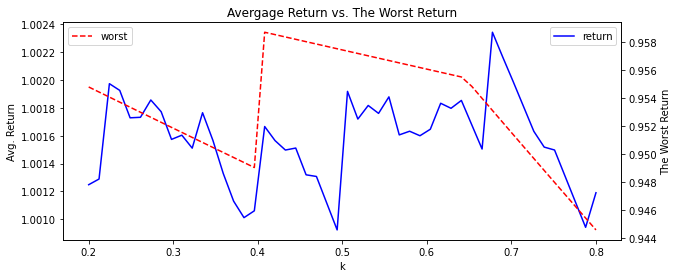

In [12]:
plt.figure(figsize=(10,4))
ax = outcome.set_index('k')['return'].plot(color='blue')
ax2 = ax.twinx()
ax2 = outcome.set_index('k')['worst'].plot(color='red', style='--')
plt.title('Avergage Return vs. The Worst Return')
ax.legend(loc=1)
ax2.legend(loc=2)
ax.set_ylabel('Avg. Return')
ax2.set_ylabel('The Worst Return')
plt.show()

<br> 이번에는 위 라인을 rolling 을 이용하여 부드럽게 해 보겠습니다. 

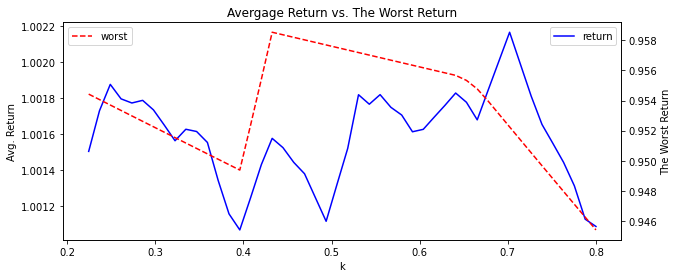

In [13]:
plt.figure(figsize=(10,4))
ax = outcome.set_index('k')['return'].rolling(3).mean().plot(color='blue')
ax2 = ax.twinx()
ax2 = outcome.set_index('k')['worst'].rolling(3).mean().plot(color='red', style='--')
plt.title('Avergage Return vs. The Worst Return')
ax.legend(loc=1)
ax2.legend(loc=2)
ax.set_ylabel('Avg. Return')
ax2.set_ylabel('The Worst Return')
plt.show()

2021년 데이터에서는 K 가 0.4 근처보다는 0.6 근처가 더 좋은 전략으로 관찰되었습니다. 과연 2022년도 그럴지 궁금합니다. 2022년 1분기 데이터를 이용해 보겠습니다. 다른 결과가 나왔습니다. K= 0.5 가 더 좋은 것 같습니다. 과거에 좋은 K 가 현재에도 좋은 K 가 아닌 것 같습니다. 단순이 과거 K 를 이용하는 것이 좋은 방법이 아니라는 것을 알았습니다.

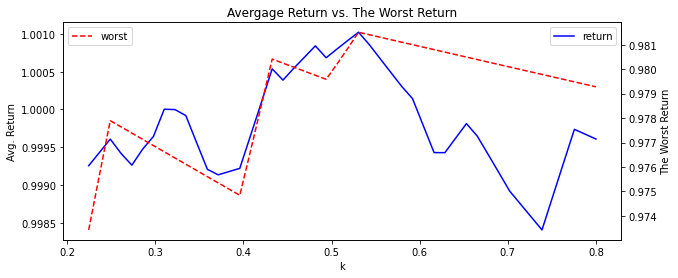

In [14]:
def avg_return(code, K):
    stock = fdr.DataReader(code,  start='2022-01-03', end='2022-03-31')    # 2022년 1분기 데이터
    stock['v'] = (stock['High'].shift(1) - stock['Low'].shift(1))*K
    stock['buy_price'] = stock['Open'] + stock['v']
    stock['buy'] = (stock['High'] > stock['buy_price'])*(stock['Low'] < stock['buy_price']).astype(int)
    stock['return'] = stock['Open'].shift(-1)/stock['buy_price']
    return stock[stock['buy']==1]['return'].mean(), stock[stock['buy']==1]['return'].min()

k_list = []
r_list = []
w_list = []

for k in list(np.linspace(0.2, 0.8)): # 0.2 ~ 0.8 까지 50 구간 list 
    r, w = avg_return('005930', k)

    k_list.append(k)       
    r_list.append(r)
    w_list.append(w)
    
outcome = pd.DataFrame({'k': k_list, 'return': r_list, 'worst': w_list})   

plt.figure(figsize=(10,4))
ax = outcome.set_index('k')['return'].rolling(3).mean().plot(color='blue')
ax2 = ax.twinx()
ax2 = outcome.set_index('k')['worst'].rolling(3).mean().plot(color='red', style='--')
plt.title('Avergage Return vs. The Worst Return')
ax.legend(loc=1)
ax2.legend(loc=2)
ax.set_ylabel('Avg. Return')
ax2.set_ylabel('The Worst Return')
plt.show()

### 종목 찾기
이전 단원에서 최적의 K 를 찾아보았는데요. 이번에는 K 를 고정하고 최적의 종목을 찾아보겠습니다. 코스피로 한정해서 종목을 찾아보겠습니다. FinanceDataReaer 의 StockListing 메소드의 인수로 'KOSPI' 를 넣으면 코스피 모든 종목을 반환합니다.

In [15]:
import FinanceDataReader as fdr 
import pandas as pd
import numpy as np

kospi_df = fdr.StockListing('KOSPI')
kospi_df.head().style.set_table_attributes('style="font-size: 12px"')

<br> nunique() 은 유니크한 종목 수를 세는 메소드입니다. 6,361 개의 종목이 있습니다. Sector 가 비어있는 종목의 경우는 일반적인 회사의 종목이 아닌 것인 것으로 보입니다. Sector 가 비어있는 종목은 제외하겠습니다. 이제 820 개의 종목만 남았습니다.

In [16]:
print(kospi_df['Symbol'].nunique())
print(kospi_df[~kospi_df['Sector'].isnull()]['Symbol'].nunique())

6151
821


<br> kospi_df 에서 필요한 컬럼 'Symbol' 과 'Name' 두 개만 kospi_list DataFrame 에 저장합니다. 그리고 종목코드 'Symbol' 과 'Name' 을 각 각 'code' 외 'name' 으로 바꿔줍니다. 그리고 나중을 위해서 결과물을 pickle 파일로 저장도 합니다.

In [17]:
kospi_list = kospi_df[~kospi_df['Sector'].isnull()][['Symbol','Name']].rename(columns={'Symbol':'code','Name':'name'})
kospi_list.to_pickle('kospi_list.pkl')
kospi_list = pd.read_pickle('kospi_list.pkl')

<br> 이제 변동성 돌파 전략의 수익율을 계산하는 함수를 불러옵니다. 일단 K 는 0.5 로 고정합니다. 모든 코스피 종목을 For-Loop 하면서 가장 수익율이 좋은 종목을 찾으면 됩니다. Loop 를 돌 때마다 종목이름, 종목코드, 평균수익율, 최대손실, 누적수익율을 list 에 저장합니다. 마지막으로 모든 list 를 모아서 하나의 DataFrame 으로 저장합니다. 800 개가 넘는 종목을 Loop 로 하나 씩 하니 시간이 많이 걸립니다. time 모듈을 이용해 총 데이터 처리시간도 측정해 봅니다. 2021년 변동성 돌파전략으로 매수할 수 있는 날이 50일 미만 경우는 무시하도록 if 문을 만들었습니다. 최종 결과를 pickle 로 저장합니다. 

In [18]:
import time

start_time = time.time()
K = 0.5

def avg_r2(code, K):
    stock = fdr.DataReader(code,  start='2021-01-03', end='2021-12-31')    
    stock['v'] = (stock['High'].shift(1) - stock['Low'].shift(1))*K
    stock['buy_price'] = stock['Open'] + stock['v']
    stock['buy'] = (stock['High'] > stock['buy_price'])*(stock['Low'] < stock['buy_price']).astype(int)
    stock['return'] = stock['Open'].shift(-1)/stock['buy_price']
    n = len(stock[stock['buy']==1])
    r = stock[stock['buy']==1]['return'].mean()
    w = stock[stock['buy']==1]['return'].min()
    c = stock[stock['buy']==1]['return'].prod()
    return n, r, w, c

code_list = []
name_list = []
return_list = []
worst_list = []
cumul_list = []

for code, name in zip(kospi_list['code'], kospi_list['name']):

    n, r, w, c = avg_r2(code, K)

    if n >= 50: # 최소한 50일 이상 거래일 존재해야 진행

        code_list.append(code)
        name_list.append(name)
        return_list.append(r)
        worst_list.append(w)
        cumul_list.append(c)
        
    else:
        continue

outcome = pd.DataFrame({'code': code_list, 'name': name_list, 'return': return_list, 'worst': worst_list, 'cumul': cumul_list})    
outcome.to_pickle('outcome.pkl')

print(f'총 프로세싱 시간 {time.time() - start_time}')

총 프로세싱 시간 125.55444192886353


<br> 저장된 결과물 outcome 을 'return' 값의 내림차순으로 함 보겠습니다. 수익율이 좋은 종목 Top 3 는 '조일알미늄', '한전기술', '포스코스틸리온' 이였습니다. Top 10 에서 최대손실율을 동시에 고려하면, 2021년에는 '미원화학'이 좋아 보입니다. 미원화학을 2021년 초부터 변동성 돌파전략으로 매수 매도를 했으면 2021년 연말에는 원금의 2.9배가 되어 있었을 것입니다. 하지만, 지나간 일입니다. 이 책의 4장부터는 데이터 분석으로 미래를 예측하는 방법을 다룹니다.

In [19]:
outcome.sort_values(by='return', ascending=False).head(10).style.set_table_attributes('style="font-size: 12px"')

<br> 미원화학의 2021년 주가흐름을 함 보겠습니다. 2021년 3월에 급등이 있었습니다. 

<AxesSubplot:xlabel='Date'>

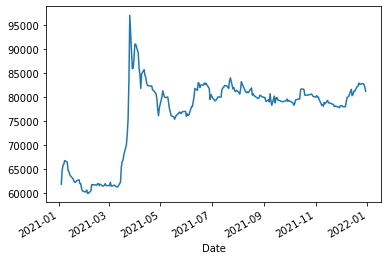

In [20]:
code = '134380' # 미원화학
stock_data = fdr.DataReader(code, start='2021-01-03', end='2021-12-31') 
stock_data['Close'].plot()